In [1]:
# Imports

import bmi
import bmi.wrapper
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive, Layout, interact
import numpy as np
import logging
import threading
import time

# Something very fishy happening if I don't define a plot first.
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()
_ = plt.figure()
plt.ion()

In [2]:
engine = r'C:\Users\vries_cy\OneDrive - Stichting Deltares\Desktop\DFM-old\share\bin\dflowfm'
wrapper = bmi.wrapper.BMIWrapper(engine=engine);
engine = r'C:\Users\vries_cy\OneDrive - Stichting Deltares\Desktop\DFM\x64\dflowfm\bin\dflowfm'
mdufile = r'C:\Users\vries_cy\PAOTM cursus\river\manning_schematic_river.mdu'

In [3]:
data = []
items = []
wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile);
wrapper.initialize();


In [4]:
# Create widgets

run = widgets.ToggleButton(
    description='Run Model',
    button_style='',
    tooltip='Description',
    icon='play'
)
update = widgets.Button(
    description='Single update',
    button_style='',
    tooltip='Update with 1 timestep',
    icon='step-forward'
)
restart = widgets.Button(
    description='Restart model',
    button_style='',
    tooltip='Restart entire model with initial inputs',
    icon='retweet'
)

settings = widgets.HTML(
    value="Welcome!",
    placeholder='Input settings'
)

play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=int(wrapper.get_end_time()),
    step=1,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider(    min=0,
    max=int(wrapper.get_end_time()))
widgets.jslink((play, 'value'), (slider, 'value'))
player = widgets.HBox([play, slider])

parameters = ["zbndz", "zbndz", "frcu"]
p_descrip = ["Boundary Water level Downstream", "Boundary Water level Upstream", "Roughness Chézy"]
style = {'description_width': 'initial'}

for p in range(len(parameters)): 
    items.append(widgets.Text(
        description=p_descrip[p],
        disabled=False,
        value=str(wrapper.get_var(parameters[p])[0]),
        placeholder=str(parameters[p]),
        style=style,
        layout=Layout(width='50vw')
    ))

In [5]:
wrapper.get_end_time()

345600.0

In [6]:
# Model specific function 

#     Automate parameter and grid sizes
def update_data():
    waterlevel = wrapper.get_var('s1')
    bedlevel = wrapper.get_var('bl')
    xz = wrapper.get_var('xz')
    data.append(dict({
        "time": wrapper.get_current_time(),
        "waterlevel": waterlevel.copy(), 
        "bedlevel": bedlevel.copy(), 
        "xz": xz.copy()
    }))
    settings.value = "Model update, timestep: {}".format(data[-1]["time"])
update_data()


In [7]:
# Standard functions for button widgets

def update_model(b=None):
#     Update the model with t = 1
    wrapper.update(1.0)
    if(data[-1]["time"] != wrapper.get_current_time()):
        update_data()

def start_loop():
#     Start the loop for running the model continuously
    while run.value == True: 
        update_model()
        if (wrapper.get_current_time() >= wrapper.get_end_time()):
            run.value = False
        time.sleep(1.0)

def run_model(change): 
#     When the run/stop model button is pressed either start the model loop or stop it
    if run.value == True: 
        run.description = "Stop Model"
        run.icon = "stop"
        update.disabled = True
        for i in items:
            i.disabled = True
        thread = threading.Thread(target=start_loop)
        thread.start()

    else: 
        run.description = "Run Model"
        run.icon = "play"
        update.disabled = False
        for i in items:
            i.disabled = False

def change_param(v):
#     set parameters in model        
    old_par = wrapper.get_var(v.placeholder)
    new_par = np.ones_like(old_par)
    if (v.description == "Boundary Water level Downstream"): 
        new_par[0] = float(v.value)
    if (v.description == "Boundary Water level Upstream"): 
        new_par[1] = float(v.value)
    wrapper.set_var(v.placeholder, new_par)
    settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])

def start_model():
#     start model
    wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
    wrapper.initialize()
    update_data()
    for i in range(len(items)): 
        items[i].value = str(wrapper.get_var(parameters[i])[0])
        
def restart_model(b=None):
#     stop the model and call function to restart the model
    del data[:]
    wrapper.finalize()
    start_model()
    settings.value = "Restarting model"

<IPython.core.display.Javascript object>


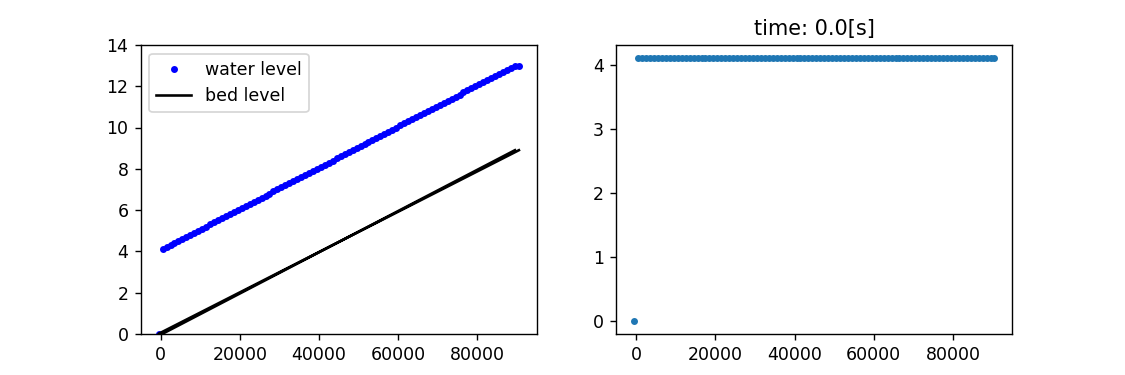

IndexError: index 1 is out of bounds for axis 0 with size 1

In [8]:
# set plot size
plt.rcParams["figure.figsize"] = (9, 3) # (w, h)

# link functions to widgets
run.observe(run_model)
update.on_click(update_model)
restart.on_click(restart_model)

def set_plot(change):
    t = change['new']
    if (t < len(data)):
        wlp.set_data(data[t]["xz"], data[t]["waterlevel"])
        blp.set_data(data[t]["xz"], data[t]["bedlevel"])
        wh.set_data(data[t]["xz"], data[t]["waterlevel"] - data[t]["bedlevel"])
        plt.title("time: " + str(data[t]["time"]) + "[s]")
        fig1.canvas.draw()
        
player.children[-1].observe(set_plot, 'value')

controls = HBox([run, update, restart])
params = VBox(items)

for i in items: 
    i.on_submit(change_param)

display(VBox([settings, controls, HBox([params]), player]))
fig, (ax1, ax2) = plt.subplots(1, 2)

wlp, = ax1.plot(data[0]["xz"], data[0]["waterlevel"], ".", color="blue", label="water level")    
blp, = ax1.plot(data[0]["xz"], data[0]["bedlevel"], color="black", label="bed level") 
ax1.set_ylim(0, 14)
ax1.legend()
plt.title("time: " + str(data[0]["time"]) + "[s]")
wh, = ax2.plot(data[0]["xz"], data[0]["waterlevel"] - data[0]["bedlevel"],'.')
